Semantic Segmentation 
============

In this exercise you are going to work on a computer vision task called semantic segmentation. In comparison to image classification the goal is not to classify an entire image but each of its pixels separately. This implies that the  output of the network is not a single scalar but a segmentation with the same shape as the input image. Think about why you should rather use convolutional than fully-connected layers for this task!

Since we already introduced the basics of PyTorch and how to train a NN we leave the model design and architecture as well as the training up to you. We only provide you with the train, validation and test dataset and recommend you to look for inspirational, existing PyTorch implementations. Due to the fairly small size of the segmentation dataset you should not train a model from scratch but consider to (at least partially) finetune weights of an already exsisting model.

The infamous  [Fully Convolutional Networks for Semantic Segmentation](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) paper might help you with finding a suitable segmentation model and architecture.

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from exercise_code.data_utils import SegmentationData, label_img_to_rgb
from torchvision import transforms
#torch.set_default_tensor_type('torch.FloatTensor')
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

MSRC-v2 Segmentation Dataset
================

Make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `exercise_code/data_utils.py`. Furthermore have a look at the labels described in `data/segmentation_data/info.html`. Especially note the label `unlabeled`. Pixels with the label `unlabeled` should neither be considered in your loss nor in the accuracy of your segmentation.

In [2]:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms_train = transforms.Compose([    
    transforms.CenterCrop(224),
    transforms.Resize(500)
])

transforms_val = transforms.Compose([
    #transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Resize(384, 0)
])

train_data = SegmentationData(image_paths_file='datasets/segmentation_data/train.txt', transforms=transforms_val, transform_normalizer=normalize)
val_data = SegmentationData(image_paths_file='datasets/segmentation_data/val.txt', transforms=transforms_val, transform_normalizer=normalize)

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 384, 384])
Segmentation size:  torch.Size([384, 384])


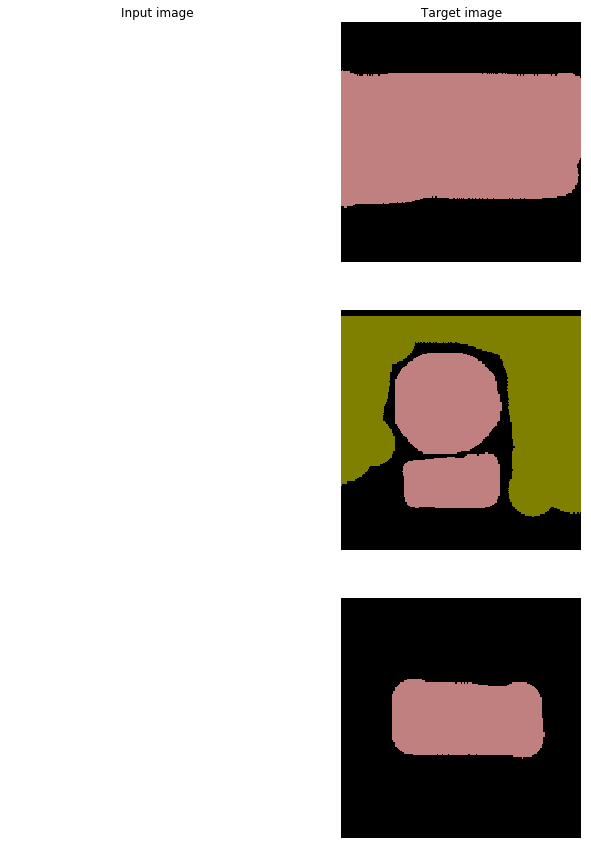

In [3]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    #plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

In [11]:
from exercise_code.segmentation_nn import SegmentationNN
def generate_cache():
    model = SegmentationNN(384, mode=1)
    model.to(device)
    model.eval()

    train_cache = []
    for img, target in train_data:
        cache = model.forward(img.unsqueeze(0))[0]
        train_cache.append((cache, target))

    val_cache = []
    for img, target in val_data:
        cache = model.forward(img.unsqueeze(0))[0]
        val_cache.append((cache, target))
    return train_cache, val_cache

In [ ]:
import pickle
with open('cache-384-100.pkl', 'wb') as handle:
    pickle.dump(generate_cache(), handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('cache-384-100.pkl', 'rb') as handle:
    train_cache, val_cache = pickle.load(handle)

Design and Train your Network
==========

Implement your network architecture in `exercise_code/classifiers/segmentation_nn.py` and adapt your `Solver` to process segmentation labels. To compensate for the dimension reduction of a typical convolution layer, you should probably include a `nn.Upsample` layer near the end of your network. Also remember to consider finetuning a model instead of training it from scratch.

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) of our `Solver` class. However, in order to ignore the `unlabeled` pixels for the computation of our loss, we have to use a customized version of the loss for the initializtation of the `Solver` class. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.

Step by step:
1. Initialize training and validation data loaders.
2. Design and initialize a convolutional neural network architecture that has input (N, C, H, W) and output (N, num_classes, H, W) and is based on an already pretrained network.
3. Initialize a solver with a loss function that considers the `unlabeled` pixels.
4. Adjust the logging of your solver to account for the `unlabeled` pixels.
5. Train a segmentation model.

In [ ]:
from exercise_code.segmentation_nn import SegmentationNN
from exercise_code.solver import Solver
import torch.nn.functional as F


train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=1)

model = SegmentationNN(384)
model.to(device)
#model.eval()
#out = model.forward(next(iter(train_loader))[0])
solver = Solver(optim_args={"lr": 1e-4, "weight_decay": 0, "momentum": 0.9}, optim=torch.optim.SGD,
               loss_func=torch.nn.CrossEntropyLoss(size_average=True, ignore_index=-1))
solver.train(model, train_loader, val_loader, log_nth=5, num_epochs=5, parameters=model.parameters_to_train())

training: [torch.Size([23, 4096, 1, 1]), torch.Size([23]), torch.Size([23, 23, 64, 64])]
START TRAIN.
[Iteration 5/345] TRAIN loss: 3.230
[Iteration 10/345] TRAIN loss: 3.210
[Iteration 15/345] TRAIN loss: 3.141
[Iteration 20/345] TRAIN loss: 3.132
[Iteration 25/345] TRAIN loss: 3.025
[Iteration 30/345] TRAIN loss: 2.970
[Iteration 35/345] TRAIN loss: 3.016
[Iteration 40/345] TRAIN loss: 3.035
[Iteration 45/345] TRAIN loss: 2.859
[Iteration 50/345] TRAIN loss: 2.876
[Iteration 55/345] TRAIN loss: 2.830
[Iteration 60/345] TRAIN loss: 2.786
[Iteration 65/345] TRAIN loss: 2.822
[Epoch 1/5] TRAIN acc/loss: 0.276/2.822
[Epoch 1/5] VAL   acc/loss: 0.331/2.683
[Iteration 74/345] TRAIN loss: 2.669
[Iteration 79/345] TRAIN loss: 2.572
[Iteration 84/345] TRAIN loss: 2.626
[Iteration 89/345] TRAIN loss: 2.692
[Iteration 94/345] TRAIN loss: 2.460
[Iteration 99/345] TRAIN loss: 2.618
[Iteration 104/345] TRAIN loss: 2.560
[Iteration 109/345] TRAIN loss: 2.669
[Iteration 114/345] TRAIN loss: 2.513
[I

In [21]:
out.size()

torch.Size([1, 23, 384, 384])

In [ ]:
np.argmax(np.squeeze(np.squeeze(out.detach().numpy(), -1)), -1)

In [10]:
np.argmax(out.detach().numpy()[2], 0)

array([[12,  1,  1, ..., 11, 16, 21],
       [11, 14, 21, ..., 12, 22, 10],
       [18,  1, 20, ..., 16,  6, 21],
       ...,
       [ 0,  5, 21, ..., 12,  6,  9],
       [21, 18,  5, ...,  6,  4, 17],
       [20, 17,  2, ..., 15,  5, 15]])

# Test your Model

Your model should easily yield a pixel accuracy of more than 60%.

In [7]:
test_data = SegmentationData(image_paths_file='datasets/segmentation_data_test/test.txt', transforms=transforms_val, transform_normalizer=normalize)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    targets_mask = targets >= 0
    test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model.train()
np.mean(test_scores)

Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/domin/virtualenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7

KeyboardInterrupt: 

# Visualization

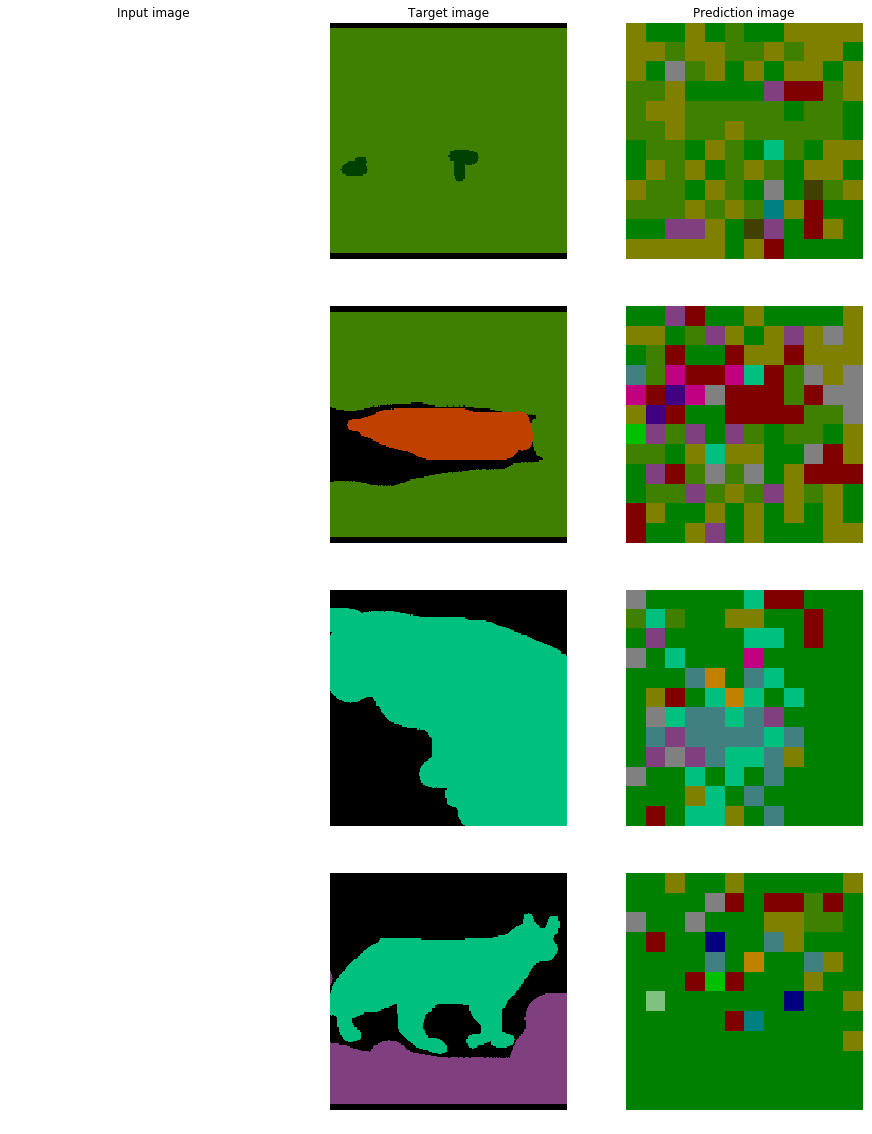

In [7]:
test_data = SegmentationData(image_paths_file='datasets/segmentation_data_test/test.txt', transforms=transforms_val, transform_normalizer=normalize)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)
num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = inputs.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    #plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

## Visualize Filter Weights
You can visualize the convolutional filters of the very first layer by running the following cell. The kernels should exhibit clear structures of differently oriented edges, corners and circles.

In [ ]:
from exercise_code.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

## Save the Model

When you are satisfied with your training, save the model for submission.

In [ ]:
model.save("models/segmentation_nn.model")

## Possible Next Steps

1. Implement and integrate a task specific metric such as [Intersection over Union (IoU)](http://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)
2. Hyperparameter optimization
3. Data augmentation ([PyTorch tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html))